# Differential gene expression analysis - code example for edgeR (pseudobulk)

Using the merged data set.

## 1. Environment setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)
library(stringr)

## 2. Reading in the annData pseudobulk object

In [6]:
adata_pb = sc.read("/home/sch/schonner/MaPra/merged_data_for_diffEx_edgeR.h5ad")
adata_pb

AnnData object with n_obs × n_vars = 542 × 32317
    obs: 'condition', 'coarse_harmonized_anno', 'batch', 'sample', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## 3. Preparing the data, constructing the design matrix and performing the DE testing

### Define a separate function to fit an edgeR GLM:
This function takes a SingleCellExperiment object as input, creates the design matrix and outputs the fitted GLM (generalized linear model). We also output the edgeR object of class DGEList to do some exploratory data analysis (EDA).

It is not possible to use *design <- model.matrix(~ 0 + group + batch)* because then the Error "R error message: 'Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset,  : \n  Design matrix not of full rank." appears later on.

In [21]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$condition, ".", colData(adata_)$manual_celltype_annotation)
    # batch <- colData(adata_)$batch
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group) # model.matrix(~ 0 + group + batch)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

### 3.1 Testing with one cell group

In [13]:
adata_pb.obs["coarse_harmonized_anno"].cat.categories

Index(['Aerocytes', 'Alveolar_macrophages', 'B_cells', 'Classical_monocytes',
       'Dendritic_cells', 'Endothelial', 'Epithelial', 'Fibroblasts',
       'Interstitial_macrophages', 'Myofibroblasts', 'NA', 'NK_cells',
       'Neutrophils', 'Non_classical_monocytes', 'SMCs', 'T_cells'],
      dtype='object')

In [14]:
adata_Neutrophils = adata_pb[adata_pb.obs["coarse_harmonized_anno"] == "Neutrophils"]
adata_Neutrophils

View of AnnData object with n_obs × n_vars = 43 × 32317
    obs: 'condition', 'coarse_harmonized_anno', 'batch', 'sample', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [15]:
# clean the sample names to make plots less crowded
adata_Neutrophils.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_Neutrophils.obs_names
]

In [22]:
%%time
%%R -i adata_Neutrophils
outs <-fit_model(adata_Neutrophils)

[1] "Dimensions before subsetting:"
[1] 32317    43
[1] ""
[1] "Dimensions after subsetting:"
[1] 139  43
[1] ""
CPU times: user 417 ms, sys: 15 ms, total: 432 ms
Wall time: 430 ms


In [23]:
%%R
fit <- outs$fit
y <- outs$y

#### 3.1.1 MDS plot:
Since we did not enter our analysis with a prior assumption that a specific gene will be up- or downregulated, we need visualizations to make sense of the DGE results. A MDS plot allows for a high level overview.

Commonly, we expect a separation between samples from different conditions. This can be seen for 'untreated', 'saline' and 'nintedanib'. There is only one sample for 'asbestos' and 'bleomycin' is distributed over the whole plot.

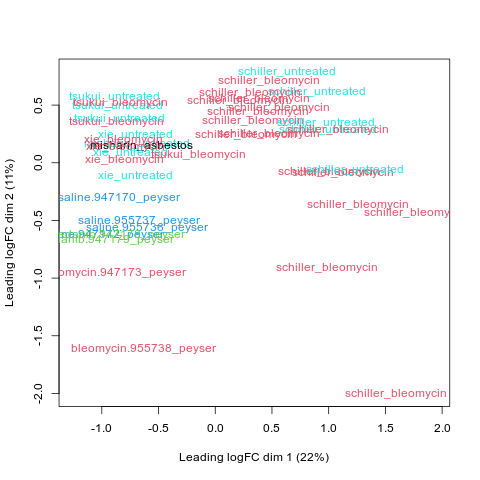

In [46]:
%%R
plotMDS(y, labels = NULL, col = as.numeric(y$samples$group))

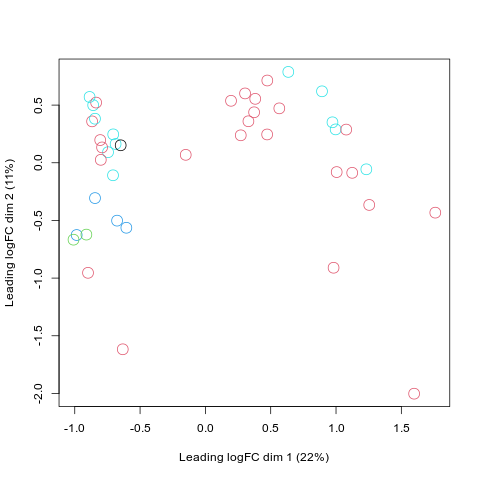

In [33]:
%%R
plotMDS(y, labels = NULL, col = as.numeric(y$samples$group), 
        pch = as.numeric(y$samples$cell), cex = 2)

#### 3.1.2 Biological Coefficient of Variation (BCV) plot:

Shows the variability of every gene on average across biological groups as a function of mean expression. For example, bcv of 0.3 indicates that there is on average 30% percent variability in the expression of genes across groups.

In the BCV plot below, we see 

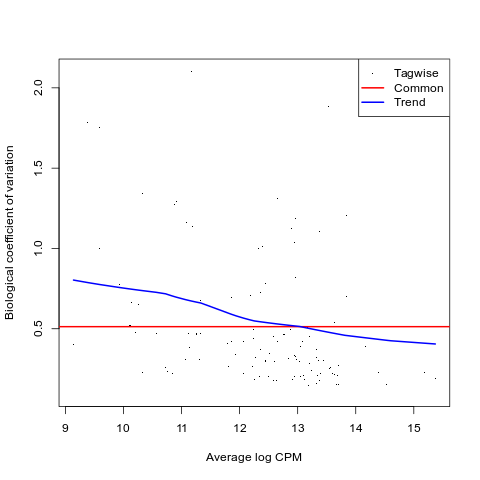

In [47]:
%%R
plotBCV(y)

#### 3.1.3 Quasi-likelihood test to find DE genes between control and stimulated conditions:

In [49]:
%%R
colnames(y$design) <- str_replace(colnames(y$design), "group", "group_")
colnames(y$design)

[1] "group_asbestos."   "group_bleomycin."  "group_nintedanib."
[4] "group_saline."     "group_untreated." 


In [52]:
%%R -o tt
myContrast <- makeContrasts('group_asbestos.-group_bleomycin.-group_nintedanib.-group_saline.-group_untreated.', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [53]:
tt.shape

(139, 5)

In [54]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
Tmsb4x,15.893883,14.848212,1137.544128,1.644951e-33,2.286482e-31
Lyz2,17.253924,14.143244,668.363600,1.395613e-28,9.699508e-27
mt-Cytb,40.115910,12.356210,781.107615,3.001820e-28,1.390843e-26
Actb,16.696969,14.535793,631.166920,4.647020e-28,1.614839e-26
B2m,19.114728,13.669745,601.868097,1.257042e-27,3.494578e-26


#### 3.1.4 Smear plot (also known as MA, M-values vs A-values, plot):

Shows the log fold-change of the genes as a function of their mean abundance. We generally observe higher logFC at low abundance ranges as read counts are more variable at low abundance resulting in large logFC estimates. If we fit a loess curve to logFC and Average logCPM values, the trend should center around zero. Any deviations from this can indicate that data has not been properly normalised.

The smear plot shows

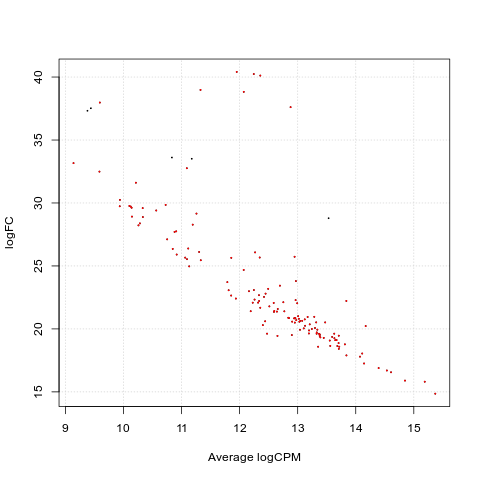

In [55]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

### 3.2 For all cell types

In [ ]:
%%time
%%R -i adata_test
outs <-fit_model(adata_test)

In [ ]:
%%R
fit <- outs$fit
y <- outs$y

In [ ]:
%%R
colnames(y$design) <- str_replace(colnames(y$design), "group", "group_")
colnames(y$design)

In [ ]:
%%R -i adata_test -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_test)$manual_celltype_annotation)) {
    print(cell_type)
    # create contrast for this cell type
    # -> only if the cell type is available for all conditions
    if ( (sum(str_detect(colnames(y$design), paste0("group_untreated.", cell_type))) > 0) &
        (sum(str_detect(colnames(y$design), paste0("group_asbestos.", cell_type))) > 0) &
        (sum(str_detect(colnames(y$design), paste0("group_bleomycin.", cell_type))) > 0) &
        (sum(str_detect(colnames(y$design), paste0("group_nintedanib.", cell_type))) > 0) &
        (sum(str_detect(colnames(y$design), paste0("group_saline.", cell_type))) > 0) ){
    
    
        contrast_temp <- paste0("group_untreated.", cell_type,
                                "-group_untreated.", cell_type,
                                "-group_bleomycin.", cell_type,
                                "-group_nintedanib.", cell_type,
                                "-group_saline.", cell_type)
        print(contrast_temp)
        myContrast <- makeContrasts(contrast_temp, levels = y$design)
        # perform QLF test 
        qlf <- glmQLFTest(fit, contrast=myContrast)
        # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
        tt <- topTags(qlf, n = Inf)
        # save in the list with the results for all the cell types
        de_per_cell_type[[cell_type]] <- tt$table
    }
}

In [ ]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

In [ ]:
sc.get.rank_genes_groups_df(adata_test, group="AT1", key="edgeR_AT1")[
    :5
]